[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danimateos/hotdog-nohotdog/05-Improving_our_thingy.ipynb)

# Improving our thingy [working title]

Hi there! Welcome back to my gentle introduction to Deep Learning. With hot dogs.

Last time we finally got our first actual taste of what Deep Learning, and specifically ConvNets, are. We got a decent classifier, but it's still far from production ready. Jian-Yang is proud, but the Periscope guys are not impressed. We need a better classifier so that we [can sell the company to them and become really rich].


[can sell the company to them and become really rich]: https://www.youtube.com/watch?v=AJsOA4Zl6Io

# Data augmentation

The idea is simple: we don't have that many images, specially of hotdogs, so let's make the most of the few we have. We'll generate new images by applying a number of transformations to the ones we have: we will zoom in, out, distort them a bit, translate them, rotate them... 

Luckily, we basically don't have to code any of this: it's already provided by the ImageDataGenerator class in Keras!

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense
from keras.optimizers import Adam
import os

base_dir = 'databackup/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

Using TensorFlow backend.


It's important to only apply this to the training generator: we don't want to be transforming the validation set, since we want it to be reflective of the kinds of images we might find in the wild.

In [2]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [3]:
my_2nd_cnn = keras.Sequential()
my_2nd_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
my_2nd_cnn.add(MaxPooling2D((2,2)))
my_2nd_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_2nd_cnn.add(MaxPooling2D((2,2)))
my_2nd_cnn.add(Flatten())
my_2nd_cnn.add(Dense(64, activation='relu'))
my_2nd_cnn.add(Dense(1, activation='sigmoid'))

my_2nd_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [4]:
%%time
my_2nd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-3),
                   metrics=['acc'])

history = my_2nd_cnn.fit_generator(train_generator,
                                   class_weight = {0: 7, 1: 1},
                                   steps_per_epoch=30,
                                   epochs=25,
                                   validation_data=validation_generator,
                                   validation_steps=10,
                                   verbose=1)

Epoch 1/25
30/30 [==============================] - 122s 4s/step - loss: 1.0534 - acc: 0.6815 - val_loss: 0.4138 - val_acc: 0.8553
Epoch 2/25
30/30 [==============================] - 20s 673ms/step - loss: 0.8585 - acc: 0.7837 - val_loss: 0.6537 - val_acc: 0.7065
Epoch 3/25
30/30 [==============================] - 20s 656ms/step - loss: 0.8202 - acc: 0.7708 - val_loss: 0.4769 - val_acc: 0.7804
Epoch 4/25
30/30 [==============================] - 20s 673ms/step - loss: 0.6956 - acc: 0.8173 - val_loss: 0.3017 - val_acc: 0.8593
Epoch 5/25
30/30 [==============================] - 20s 674ms/step - loss: 0.7376 - acc: 0.7886 - val_loss: 0.3053 - val_acc: 0.8654
Epoch 6/25
30/30 [==============================] - 20s 657ms/step - loss: 0.6671 - acc: 0.8192 - val_loss: 0.4276 - val_acc: 0.8117
Epoch 7/25
30/30 [==============================] - 20s 652ms/step - loss: 0.7145 - acc: 0.8023 - val_loss: 0.3390 - val_acc: 0.8492
Epoch 8/25
30/30 [==============================] - 20s 682ms/step - lo

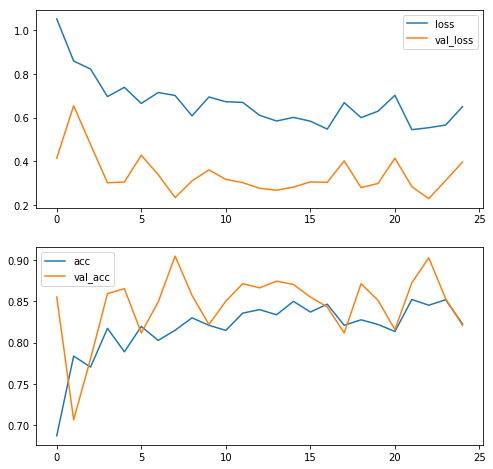

In [5]:
from mateosio import plot_training_histories
%matplotlib inline

plot_training_histories(history);

0.415384615385 0.947368421053


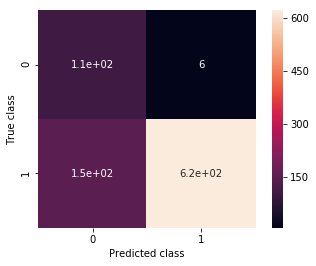

In [6]:
from mateosio import plot_confusion_matrix

ax, precision, recall = plot_confusion_matrix(my_2nd_cnn, validation_generator_noshuffle)
print(precision, recall)

Wow, now I am underfitting! I guess that means I can make my model even a bit more complex, let's see

### One more layer

In [7]:
my_3rd_cnn = keras.Sequential()
my_3rd_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
my_3rd_cnn.add(MaxPooling2D((2,2)))
my_3rd_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_3rd_cnn.add(MaxPooling2D((2,2)))
my_3rd_cnn.add(Flatten())
my_3rd_cnn.add(Dense(128, activation='relu'))
my_3rd_cnn.add(Dense(128, activation='relu'))
my_3rd_cnn.add(Dense(64, activation='relu'))
my_3rd_cnn.add(Dense(1, activation='sigmoid'))

my_3rd_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

In [8]:
%%time
my_3rd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-3),
                   metrics=['acc'])

history = my_3rd_cnn.fit_generator(train_generator,
                                   class_weight = {0: 7, 1: 1},
                                   steps_per_epoch=30,
                                   epochs=20,
                                   validation_data=validation_generator,
                                   validation_steps=10,
                                   verbose=1)

Epoch 1/20
30/30 [==============================] - 23s 773ms/step - loss: 1.0655 - acc: 0.6366 - val_loss: 0.4718 - val_acc: 0.7561
Epoch 2/20
30/30 [==============================] - 20s 664ms/step - loss: 0.8330 - acc: 0.7680 - val_loss: 0.8183 - val_acc: 0.5729
Epoch 3/20
30/30 [==============================] - 20s 676ms/step - loss: 0.7935 - acc: 0.7830 - val_loss: 0.5478 - val_acc: 0.6953
Epoch 4/20
30/30 [==============================] - 20s 669ms/step - loss: 0.7688 - acc: 0.7760 - val_loss: 0.2606 - val_acc: 0.8988
Epoch 5/20
30/30 [==============================] - 20s 671ms/step - loss: 0.7634 - acc: 0.7770 - val_loss: 0.3780 - val_acc: 0.8117
Epoch 6/20
30/30 [==============================] - 20s 668ms/step - loss: 0.7331 - acc: 0.7857 - val_loss: 0.3855 - val_acc: 0.8138
Epoch 7/20
30/30 [==============================] - 20s 660ms/step - loss: 0.7614 - acc: 0.8078 - val_loss: 0.3675 - val_acc: 0.8360
Epoch 8/20
30/30 [==============================] - 20s 666ms/step - 

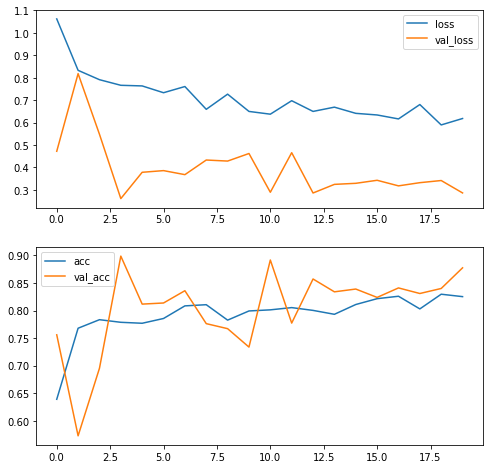

In [9]:
plot_training_histories(history);

0.509202453988 0.728070175439


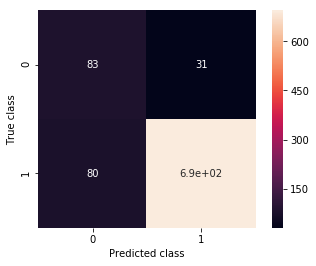

In [10]:
ax, precision, recall = plot_confusion_matrix(my_3rd_cnn, validation_generator_noshuffle)
print(precision, recall)

One of the best pieces of advice I got from Jeremy Howard's Deep Learning for Coders is that you should first attempt to overfit, then deal with that through regularization. It makes a lot of sense: once you have overfitting, you know you've juiced your model to the max. If you don't, you don't know whether there is still a lot of life left on it or it's at the maximum performance it's going to get. Let's go for that overfitting. 

Once a model stops improving with a particular learning rate, it's often useful to reduce the learning rate and keep training.

In [11]:
%%time
my_3rd_cnn.compile(loss='binary_crossentropy',
                   optimizer=Adam(lr=1e-4),
                   metrics=['acc'])

history_pt2 = my_3rd_cnn.fit_generator(train_generator,
                                       class_weight = {0: 7, 1: 1},
                                       steps_per_epoch=30,
                                       epochs=30,
                                       validation_data=validation_generator,
                                       validation_steps=10,
                                       verbose=1)

Epoch 1/30
30/30 [==============================] - 23s 774ms/step - loss: 0.6566 - acc: 0.7980 - val_loss: 0.2879 - val_acc: 0.8573
Epoch 2/30
30/30 [==============================] - 20s 671ms/step - loss: 0.5584 - acc: 0.8387 - val_loss: 0.3417 - val_acc: 0.8289
Epoch 3/30
30/30 [==============================] - 20s 660ms/step - loss: 0.5600 - acc: 0.8425 - val_loss: 0.3182 - val_acc: 0.8320
Epoch 4/30
30/30 [==============================] - 20s 667ms/step - loss: 0.5453 - acc: 0.8314 - val_loss: 0.3467 - val_acc: 0.8330
Epoch 5/30
30/30 [==============================] - 20s 680ms/step - loss: 0.5742 - acc: 0.8280 - val_loss: 0.3430 - val_acc: 0.8259
Epoch 6/30
30/30 [==============================] - 20s 658ms/step - loss: 0.5122 - acc: 0.8405 - val_loss: 0.2929 - val_acc: 0.8623
Epoch 7/30
30/30 [==============================] - 20s 669ms/step - loss: 0.5503 - acc: 0.8429 - val_loss: 0.3180 - val_acc: 0.8512
Epoch 8/30
30/30 [==============================] - 21s 683ms/step - 

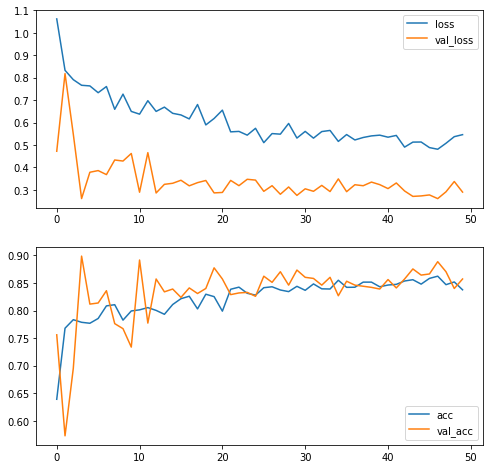

In [12]:
plot_training_histories(history, history_pt2);

0.456221198157 0.868421052632


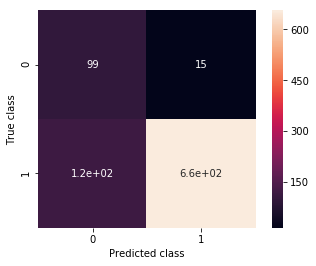

In [13]:
ax, precision, recall = plot_confusion_matrix(my_3rd_cnn, validation_generator_noshuffle)
print(precision, recall)